# MNIST Dataset Training

## Short description:
This Notebook trains a neural network based on the MNIST dataset. The goal is to generate a model that can evaluate and predict the handwritten number input (0-9) of a user. This notebook provides the other program (including the user interface) the CNN model.

In [1]:
import gzip
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import seaborn as sn
import pandas as pd
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
FILENAME = "MNIST"

def open_images(filename):
    with gzip.open(filename, "rb") as file:
        data = file.read()
        return np.frombuffer(data, dtype=np.uint8, offset=16).reshape(-1, 28, 28).astype(np.float32)


def open_labels(filename):
    with gzip.open(filename, "rb") as file:
        data = file.read()
        return np.frombuffer(data, dtype=np.uint8, offset=8)

Using TensorFlow backend.


In [2]:
# loading the data into the variables

X_train = open_images("./res/train-images-idx3-ubyte.gz")
X_train = X_train.astype(np.float32) / 255.
y_train = open_labels("./res/train-labels-idx1-ubyte.gz")

X_test = open_images("./res/t10k-images-idx3-ubyte.gz")
X_test = X_test.astype(np.float32) / 255.
y_test = open_labels("./res/t10k-labels-idx1-ubyte.gz")

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# print the shapes
print("X_train: {}".format(X_train.shape))
print("X_test: {}".format(X_test.shape))
print("y_train: {}".format(y_train.shape))
print("y_test: {}".format(y_test.shape))

X_train: (60000, 28, 28)
X_test: (10000, 28, 28)
y_train: (60000, 10)
y_test: (10000, 10)


In [3]:
storedMetrics = []

# callback class used for the training of the network
# used to evaluate the network based on the whole dataset after every epoch finishes
class storeMetrics(Callback):
    def on_epoch_end(self, epoch, logs={}):
        loss, accuracy = self.model.evaluate(X_test.reshape(-1, 28, 28, 1), y_test)
        storedMetrics.append((accuracy, loss))

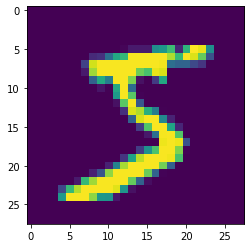

Number: 5


In [4]:
# show the first number of the dataset with the corresponding result
plt.imshow(X_train[0])
plt.show()
print("Number: {}".format(y_train[0].argmax()))

# Add the neural network with CNN-layers

In [5]:
# create the model
model = Sequential()

# 1. CNN Layer
model.add(Conv2D(28, kernel_size=(3, 3), input_shape=(28, 28, 1), activation="tanh", padding="same"))
model.add(Conv2D(28, kernel_size=(3, 3), activation="tanh", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2. CNN Layer
model.add(Conv2D(56, kernel_size=(3, 3), activation="tanh", padding="same"))
model.add(Conv2D(56, kernel_size=(3, 3), activation="tanh", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3. Output Layer
model.add(Flatten())
model.add(Dense(128, activation="tanh"))
model.add(Dense(10, activation="softmax"))

# compile the model and display the structure of the network
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 28)        280       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 28)        7084      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 28)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 28)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 56)        14168     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 56)        28280     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 56)         

In [6]:
# train the model
history = model.fit(X_train.reshape(-1, 28, 28, 1),
                    y_train,
                    batch_size=1000,
                    epochs=10,
                    shuffle=True,
                    callbacks=[storeMetrics()])

_, accuracy = model.evaluate(X_test.reshape(-1, 28, 28, 1), y_test)

# save the model and the variables
model.save("./output/{}-{}-Network.h5".format(FILENAME, round(accuracy * 100)))

with open("./output/{}-{}-saved-variables.pkl".format(FILENAME, round(accuracy * 100)), "wb") as file:
    pickle.dump([storedMetrics, history], file)

# to open the stored variables use the following code with the correct filename
"""
with open("./output/{}-{}-saved-variables.pkl".format(FILENAME, ACCURACY), "rb") as file:
    storedMetrics, history = pickle.load(file)
"""

print("Accuracy: {}".format(accuracy))

Epoch 1/10
10000/10000 [==============================] - 5s 549us/step
Epoch 2/10
10000/10000 [==============================] - 6s 621us/step
Epoch 3/10
10000/10000 [==============================] - 6s 625us/step
Epoch 4/10
10000/10000 [==============================] - 6s 626us/step
Epoch 5/10
10000/10000 [==============================] - 6s 627us/step
Epoch 6/10
10000/10000 [==============================] - 6s 649us/step
Epoch 7/10
10000/10000 [==============================] - 6s 629us/step
Epoch 8/10
10000/10000 [==============================] - 6s 635us/step
Epoch 9/10
10000/10000 [==============================] - 7s 660us/step
Epoch 10/10
10000/10000 [==============================] - 7s 669us/step
Accuracy: 0.9905999898910522


# Plot the learning history and the confusion matrix

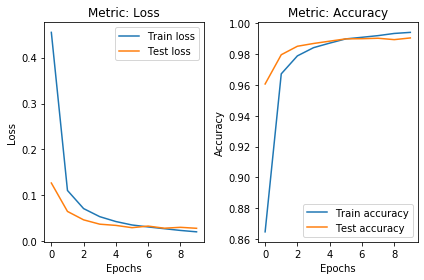

In [7]:
# create 2 subplots, that the accuracy is displayed beside the loss plot
fig, axes = plt.subplots(1, 2)

# plot the loss factor
plt.subplot(1, 2, 1)
train_loss, = plt.plot(history.history["loss"], label="Train loss")
test_loss, = plt.plot([i[1] for i in storedMetrics], label="Test loss")

plt.title("Metric: Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()


# plot the accuracy
plt.subplot(1, 2, 2)
train_accuracy, = plt.plot(history.history["accuracy"], label="Train accuracy")
test_accuracy, = plt.plot([i[0] for i in storedMetrics], label="Test accuracy")

plt.title("Metric: Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# finally show and save the plot
plt.tight_layout()
plt.savefig("./output/{}-{}-learning-graph.pdf".format(FILENAME, round(accuracy * 100)))

In [8]:
predictions = model.predict(X_test.reshape(-1, 28, 28, 1))
prediction_list, actual_list = [], []

for prediction in predictions:
    prediction_list.append(np.argmax(prediction))
    
for actual_result in y_test:
    actual_list.append(np.argmax(actual_result))

# generate the matrix
cm = confusion_matrix(actual_list, prediction_list)
cm

array([[ 974,    0,    2,    0,    0,    0,    1,    1,    2,    0],
       [   0, 1127,    2,    0,    0,    1,    3,    0,    2,    0],
       [   0,    0, 1025,    0,    1,    0,    0,    4,    2,    0],
       [   0,    0,    3, 1004,    0,    1,    0,    0,    1,    1],
       [   0,    0,    0,    0,  974,    0,    0,    1,    0,    7],
       [   2,    0,    0,    6,    0,  882,    2,    0,    0,    0],
       [   4,    2,    1,    0,    1,    3,  947,    0,    0,    0],
       [   0,    1,   10,    0,    0,    0,    0, 1014,    1,    2],
       [   4,    0,    4,    2,    1,    0,    0,    2,  958,    3],
       [   0,    2,    0,    0,    3,    0,    0,    3,    0, 1001]],
      dtype=int64)

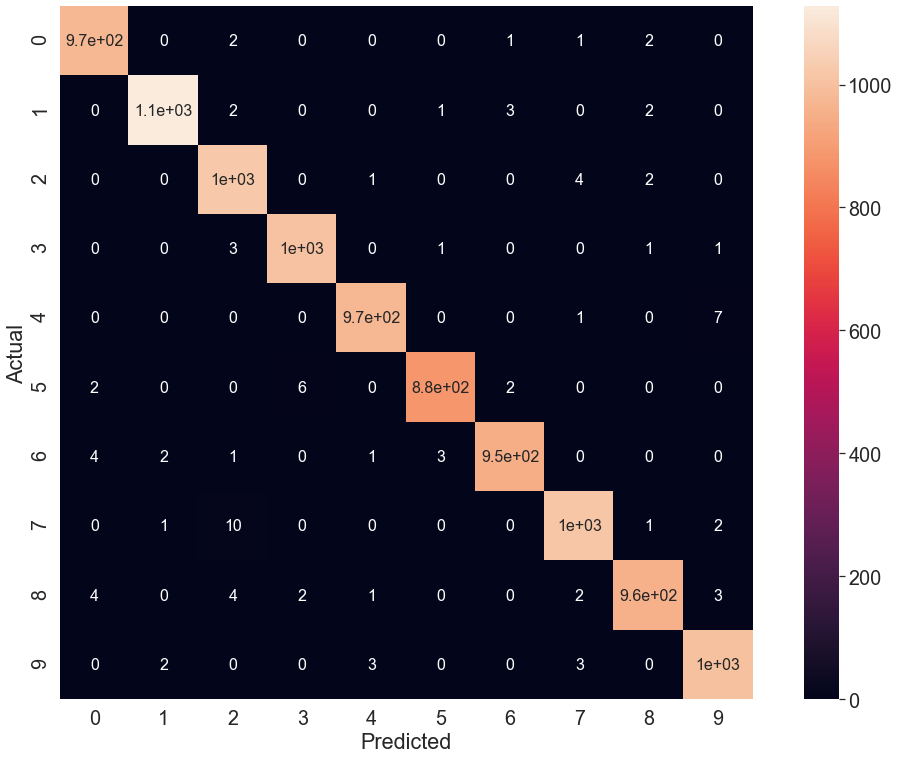

In [9]:
# visualize the confusion matrix
df_cm = pd.DataFrame(cm, columns=np.unique(actual_list), index = np.unique(actual_list))
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
sn.set(font_scale=1.8)

plt.figure(figsize=(15, 11))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, square=True)

# finally show and save the plot
plt.tight_layout()
plt.savefig("./output/{}-{}-ConfusionMatrix.pdf".format(FILENAME, round(accuracy)))